## LCPB 20-21 exercise 2

### Saverio Monaco

### Gerardo Carmona

### Hilario Capettini

0. Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
import time
import math

In [2]:
fname = "DATA/sequences16.csv"
sx, sy = np.loadtxt(fname,delimiter=',',
                   usecols=(0,1), unpack=True, dtype=str)
N = len(sy)

Ls = len(sx[0])


perc_train = 0.8 # I kept the same train-test ratio as in the lesson
N_train = int(N*perc_train)
N_test = N - N_train

print('Size of the sequences:   ',Ls)
print('Size of the data:        ',N)
print('Size of the training set:',N_train)
print('Size of the test set:    ',N_test)


Size of the sequences:    16
Size of the data:         3000
Size of the training set: 2400
Size of the test set:     600


In [3]:
# Just printing some datas to check it
# I noticed this isn't the same rule in the lessons, so it is unkown
for _ in range(10):
    print(sx[_],sy[_])


AAGGTCTGCCGGCCGA 1
CCTCCCTTATGGGGGA 0
TCTCTCGGAACTGTCA 0
GTTAAACGTTACATCT 0
TTAAATGCTGCTGATC 1
ATGGAACGAGACGCCG 1
AGGCCAAATGAGGATA 1
CGAGTACACTTAGGCC 0
GAAATAAATCTTATAG 0
AATGTAGATATGGAGT 0


In [4]:
# Converting the label set to int values:
print(sy[0],type(sy[0]))
y = sy.astype(int)
print(y[0],type(y[0]))

1 <class 'numpy.str_'>
1 <class 'numpy.int64'>


In [5]:
# Letters and number of letters
Q = ['A', 'C', 'G', 'T']
Nc = 4

# building the dictionary
onehc = {Q[i]: i for i in range (Nc)}

L = Ls * Nc # lenght of the input array (64)

# The following cycle will transform the input vectors (for ex.: AAGGTCTGCCGGCCGA) in a
# binary like way
#
# A = 1000
# C = 0100
# G = 0010
# T = 0001
#
#   A    A    G    G    T    C   ...
# 1000 1000 0010 0010 0001 0100
x = np.zeros((N,L))
for n in range(N): #for all the samples
    for i in range(Ls): # for every character
        x[n][i*4 + onehc[sx[n][i]]] = 1
        
print(sx[0])
print(x[0])

AAGGTCTGCCGGCCGA
[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


In [6]:
(x_train, y_train) = (x[:N_train],y[:N_train])
(x_test, y_test) = (x[N_train:],y[N_train:])

# Check the fraction of datas equal to one
print(y_train.sum() / N_train)
print(y_test.sum() / N_test)

0.24333333333333335
0.25833333333333336


1. Is the model converging with a smaller database of samples with longer sequences? By converging we mean reducing significantly the validation loss function.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
48/48 [==============================] - 1s 22ms/step - loss: 0.5745 - accuracy: 0.7329 - val_loss: 0.53

48/48 [==============================] - 1s 13ms/step - loss: 0.0514 - accuracy: 0.9850 - val_loss: 0.9651 - val_accuracy: 0.7917
Epoch 52/60
48/48 [==============================] - 1s 11ms/step - loss: 0.0420 - accuracy: 0.9896 - val_loss: 0.9752 - val_accuracy: 0.7967
Epoch 53/60
48/48 [==============================] - 1s 15ms/step - loss: 0.0427 - accuracy: 0.9875 - val_loss: 0.9384 - val_accuracy: 0.7917
Epoch 54/60
48/48 [==============================] - 1s 18ms/step - loss: 0.0477 - accuracy: 0.9858 - val_loss: 1.0449 - val_accuracy: 0.7983
Epoch 55/60
48/48 [==============================] - 1s 14ms/step - loss: 0.0508 - accuracy: 0.9850 - val_loss: 0.9831 - val_accuracy: 0.7867
Epoch 56/60
48/48 [==============================] - 1s 12ms/step - loss: 0.0479 - accuracy: 0.9850 - val_loss: 1.0895 - val_accuracy: 0.7767
Epoch 57/60
48/48 [==============================] - 1s 16ms/step - loss: 0.0514 - accuracy: 0.9808 - val_loss: 0.9757 - val_accuracy: 0.7833
Epoch 58/60
48/48 

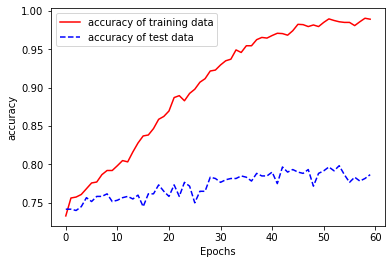

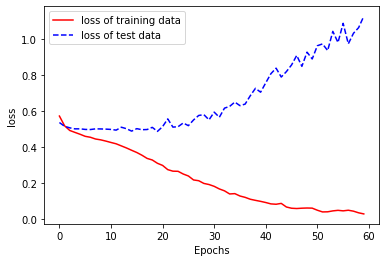

In [7]:
# I MADE THE SAME TRAINING IMPLEMENTING 3 FUNCTIONS
# layer_i is an array representing a hidden layer used to create a neural network:
# layer_i = [nodes, activation, dropout_ratio]
# hidden_layers is a array of the hidden layers
layer_1 = [L/2, 'relu', 0]
layer_2 = [L/4, 'relu', .2]
hidden_layers = [layer_1,layer_2]

# optimization chosen
opt = SGD(learning_rate=0.01, momentum=0.9, nesterov= True)

# the first function creates the Neural Network, it needs the input dimension and the array of layers
def createmodel(input_dim, hidden_layers):
    model = Sequential()
    
    # we add the first layer (input layer)
    model.add(Dense(input_dim, input_shape=(input_dim,)))
    
    # we add the hidden layers
    for layer in hidden_layers:
        model.add(Dense(layer[0],activation=layer[1]))
        if layer[2]:
            model.add(Dropout(layer[2]))
    
    # we add the output layer
    model.add(Dense(1,activation='sigmoid'))
    print(model.summary())
    
    return model

# the second function trains the model created with createmodel, as a input it needs the output of createmodels
# the optimization and the arguments of model.fit() (except for shuffle)
def trainmodel(model, opt, *args, **kwargs):
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    fit = model.fit(*args, **kwargs, shuffle = True)
    '''fit = model.fit(x_train, y_train,
                    epochs = 60, batch_size = 50,
                    validation_data = (x_test,y_test),
                    shuffle = True)'''
    
    return fit

# the third function takes the output of trainmodel and plot the loss of training data and test data
def plotmodel(fit):
    for obs in ('accuracy', 'loss'):
        plt.figure(figsize=(6,4))
        plt.plot(fit.history[obs], 'r', label = obs + ' of training data')
        plt.plot(fit.history['val_'+obs], 'b--', label = obs + ' of test data')
        plt.ylabel(obs)
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()
        
plotmodel(trainmodel(createmodel(L,hidden_layers), opt, x_train, y_train,
           epochs=60, batch_size=50, validation_data= (x_test, y_test)))


In [ ]:
np.random.seed(123)

model = Sequential() #start of implementing a neural network in keras

#  x
#  x
#  x     h
#  x     h
#  x     h     h    o (0,1)
#  x     h
#  x
#  x
#             drop
# FIRST LAYER (INPUT)
model.add(Dense(L, input_shape=(L,),activation='relu')) # Dense stands for a normal layer

# SECOND LAYER (HIDDEN 1)
model.add(Dense(L/2,activation='relu'))

# THIRD LAYER (HIDDEN 2)
model.add(Dense(L/4,activation='relu'))
model.add(Dropout(0.2))

# FORTH LAYER (OUTPUT) introducing dropouts
model.add(Dense(1,activation='sigmoid')) #we need an activation function from 0 to 1

print(model.summary())

In [ ]:
opt1 = SGD(learning_rate=0.01, momentum=0.9, nesterov= True)

model.compile(loss='binary_crossentropy',
              optimizer=opt1,
              metrics=['accuracy'])

fit = model.fit(x_train, y_train,
                epochs = 60, batch_size = 50,
                validation_data = (x_test,y_test),
                shuffle = True)

In [ ]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(6,4))
    plt.plot(fit.history[obs], 'r', label = obs + ' of training data')
    plt.plot(fit.history['val_'+obs], 'b--', label = obs + ' of test data')
    plt.ylabel(obs)
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

2. Try to improve the performance of the DNN over the validation data set by “augmenting”
the training data: For every sample there are L s -1 periodic shifts of the kind
AAACCCTTTGGG→ GAAACCCTTTGG → GGAAACCCTTTG→ etc.
We know that they can break the keys and provide a sample x’[n] with wrong label y[n]
(which is the label of original sample x[n]), but they also enlarge the number of good
samples for the DNN. Which of the two effects is prevalent?
Is the situation improving by augmenting the training data from N t real samples to L s *N t ones with this procedure?

In [8]:
rot = lambda A: [A[i:]+A[:i] for i in range(len(A))]

In [9]:
sxx = []
syy = np.zeros(len(sx)*Ls)
for i in range(len(sx)):
    sxx= np.append(sxx,rot(sx[i]))
    syy[i*Ls:(i+1)*Ls] = sy[i]
syy = syy.astype(int)
#syy.astype(int)
print('Original number of samples',len(sx))
print('Augmented number of samples',len(sxx))

Original number of samples 3000
Augmented number of samples 48000


In [10]:
N = len(syy)

Ls = len(sxx[0])

perc_train = 0.8 # I kept the same train-test ratio as in the lesson
N_train = int(N*perc_train)
N_test = N - N_train

print('Size of the sequences:   ',Ls)
print('Size of the data:        ',N)
print('Size of the training set:',N_train)
print('Size of the test set:    ',N_test)

Size of the sequences:    16
Size of the data:         48000
Size of the training set: 38400
Size of the test set:     9600


In [11]:
y = syy
x = np.zeros((N,L))
for n in range(N): #for all the samples
    for i in range(Ls): # for every character
        x[n][i*4 + onehc[sxx[n][i]]] = 1
        
print(sxx[0])
print(x[0])

AAGGTCTGCCGGCCGA
[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


In [12]:
(x_train, y_train) = (x[:N_train],y[:N_train])
(x_test, y_test) = (x[N_train:],y[N_train:])

# Check the fraction of datas equal to one
print(y_train.sum() / N_train)
print(y_test.sum() / N_test)

0.24333333333333335
0.25833333333333336


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
768/768 [==============================] - 9s 11ms/step - loss: 0.5130 - accuracy: 0.7595 - val_loss: 

Epoch 51/60
768/768 [==============================] - 9s 11ms/step - loss: 0.2222 - accuracy: 0.9206 - val_loss: 0.2294 - val_accuracy: 0.9172
Epoch 52/60
768/768 [==============================] - 11s 14ms/step - loss: 0.2194 - accuracy: 0.9232 - val_loss: 0.2387 - val_accuracy: 0.9108
Epoch 53/60
768/768 [==============================] - 9s 11ms/step - loss: 0.2216 - accuracy: 0.9207 - val_loss: 0.2278 - val_accuracy: 0.9161
Epoch 54/60
768/768 [==============================] - 10s 14ms/step - loss: 0.2201 - accuracy: 0.9229 - val_loss: 0.2469 - val_accuracy: 0.9081
Epoch 55/60
768/768 [==============================] - 12s 16ms/step - loss: 0.2223 - accuracy: 0.9214 - val_loss: 0.2262 - val_accuracy: 0.9198
Epoch 56/60
768/768 [==============================] - 12s 15ms/step - loss: 0.2199 - accuracy: 0.9217 - val_loss: 0.2278 - val_accuracy: 0.9174
Epoch 57/60
768/768 [==============================] - 13s 17ms/step - loss: 0.2203 - accuracy: 0.9218 - val_loss: 0.2376 - val_accu

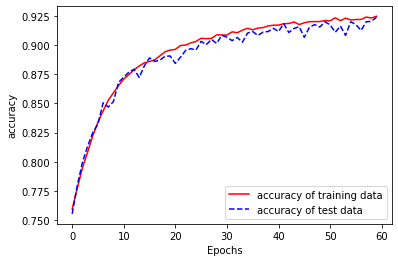

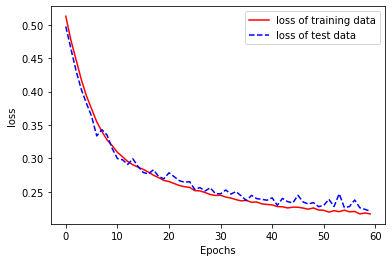

In [13]:
#Trainning of the network
plotmodel(trainmodel(createmodel(L,hidden_layers), opt, x_train, y_train,
           epochs=60, batch_size=50, validation_data= (x_test, y_test)))

In [14]:
for i in range(16):
    print(sxx[i],syy[i])

AAGGTCTGCCGGCCGA 1
AGGTCTGCCGGCCGAA 1
GGTCTGCCGGCCGAAA 1
GTCTGCCGGCCGAAAG 1
TCTGCCGGCCGAAAGG 1
CTGCCGGCCGAAAGGT 1
TGCCGGCCGAAAGGTC 1
GCCGGCCGAAAGGTCT 1
CCGGCCGAAAGGTCTG 1
CGGCCGAAAGGTCTGC 1
GGCCGAAAGGTCTGCC 1
GCCGAAAGGTCTGCCG 1
CCGAAAGGTCTGCCGG 1
CGAAAGGTCTGCCGGC 1
GAAAGGTCTGCCGGCC 1
AAAGGTCTGCCGGCCG 1


In [15]:
permutation = np.random.permutation(sxx.shape[0])

sxx = sxx[permutation] 
syy = syy[permutation]

In [16]:
for i in range(16):
    print(sxx[i],syy[i])

CAAGGCTCCAGCTAGA 1
ACCAAGTCTTAGCCCC 0
CCGCTGTCGCCGAATT 1
GGTGTGTCTTTCCATC 0
TGGACTCGTATAACAG 0
AATCCTAGCGTTCTTT 0
TTCTCCACAATATATA 0
TTCCTAACCACTGTTT 0
AGGCGGAAAGCCCGGG 1
GGAGTGAAAAATTCCC 0
CCCAATGACCTGCTTT 0
GGCCTGATACGTCGGC 0
AACTGGTCGCATGTGA 0
CGCAGCTTGGTTGGCG 0
CGGATATTGATACATA 0
CGAGACCGTCGTGCAT 0


In [17]:
y = syy
x = np.zeros((N,L))
for n in range(N): #for all the samples
    for i in range(Ls): # for every character
        x[n][i*4 + onehc[sxx[n][i]]] = 1
        
print(sxx[0])
print(x[0])

CAAGGCTCCAGCTAGA
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


In [18]:
(x_train, y_train) = (x[:N_train],y[:N_train])
(x_test, y_test) = (x[N_train:],y[N_train:])

# Check the fraction of datas equal to one
print(y_train.sum() / N_train)
print(y_test.sum() / N_test)

0.24588541666666666
0.248125


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
768/768 [==============================] - 10s 12ms/step - loss: 0.5045 - accuracy: 0.7625 - val_loss:

Epoch 51/60
768/768 [==============================] - 7s 9ms/step - loss: 0.2074 - accuracy: 0.9291 - val_loss: 0.2384 - val_accuracy: 0.9150
Epoch 52/60
768/768 [==============================] - 7s 10ms/step - loss: 0.2072 - accuracy: 0.9286 - val_loss: 0.2460 - val_accuracy: 0.9144
Epoch 53/60
768/768 [==============================] - 7s 9ms/step - loss: 0.2060 - accuracy: 0.9296 - val_loss: 0.2294 - val_accuracy: 0.9180
Epoch 54/60
768/768 [==============================] - 7s 9ms/step - loss: 0.2066 - accuracy: 0.9290 - val_loss: 0.2385 - val_accuracy: 0.9201
Epoch 55/60
768/768 [==============================] - 7s 9ms/step - loss: 0.2059 - accuracy: 0.9305 - val_loss: 0.2315 - val_accuracy: 0.9178
Epoch 56/60
768/768 [==============================] - 7s 9ms/step - loss: 0.2032 - accuracy: 0.9303 - val_loss: 0.2423 - val_accuracy: 0.9166
Epoch 57/60
768/768 [==============================] - 7s 10ms/step - loss: 0.2029 - accuracy: 0.9308 - val_loss: 0.2375 - val_accuracy: 0.92

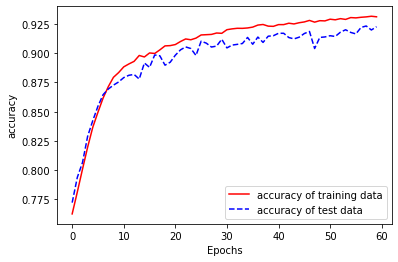

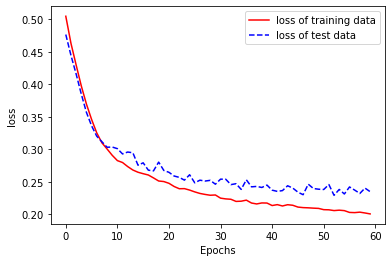

In [19]:
#Trainning of the network
plotmodel(trainmodel(createmodel(L,hidden_layers), opt, x_train, y_train,
           epochs=60, batch_size=50, validation_data= (x_test, y_test)))

3. Implement a “grid search” as shown in NB11 to improve one or more of the aspects or
parameters of the model. Possible tests include: different activation units (sigmoid, relu, elu,
etc.), different minimization algorithms (ADAM, RMSprop, Nesterov, etc.), different
dropouts, etc.

4. See if any rescaling of data may improve the results. For instance one may use [-0.5,+0.5]
instead of [0,1] for every bit of x[n].